In [ ]:
%load_ext tensorboard

Load modules

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from keras import layers
import datetime

from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score

Const

In [2]:
log_dir = "../logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
batch_size=32

path="../data/"
os.listdir(path)

['Fixated.csv', 'heart+disease', 'metadata.txt']

## Pre Modelling

Read dataset

In [3]:
df=pd.read_csv(path+"fixated.csv")
labeltarget=["Tidak", "Ya"]

Train Test split

In [4]:
#train test split
X=df.copy()
y=X.pop("target")
train_data, test_data, train_value, test_value = train_test_split(X, y, train_size= 0.8)

Necessities for the model

In [43]:
#callbacks
def tensorboardlogger():
    return [keras.callbacks.ModelCheckpoint(log_dir+"/callbacks", save_weights_only=True),
            tf.keras.callbacks.TensorBoard(log_dir)]


class SelectiveProgbarLogger(tf.keras.callbacks.ProgbarLogger):
    def __init__(self, verbose, epoch_interval, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.default_verbose = verbose
        self.epoch_interval = epoch_interval
    
    def on_epoch_begin(self, epoch, *args, **kwargs):
        self.verbose = (
            0 
                if epoch % self.epoch_interval != 0 
                else self.default_verbose
        )
        super().on_epoch_begin(epoch, *args, **kwargs)

#metrics history visualization
def theplot(history):
    fig = plt.figure(figsize=(10,10))
    ax=fig.add_subplot(2,1,1)
    ax.plot(history.history["binary_accuracy"], label="binary_accuracy", c="blue")
    ax.plot(history.history["val_binary_accuracy"], label="val_binary_accuracy", c="orange")
    ax.set_xlabel("epochs")
    ax.set_ylabel("accuracy")
    ax.legend(loc="lower right")
    ax=fig.add_subplot(2,1,2)
    ax.plot(history.history["loss"], label="loss", c="blue")
    ax.plot(history.history["val_loss"], label="val_loss", c="orange")
    ax.legend(loc="lower right")
    ax.set_ylim(0,1)
    ax.set_xlabel("epochs")
    ax.set_ylabel("losses")
    
#change to binary [0,1]
def predict(model, features):
    predicted=model.predict(features)
    predicted = tf.where(predicted < 0.5, 0, 1)
    return np.array(predicted).flatten()


## Modelling

1st try

In [68]:
def build_and_compile_model():
  model = keras.Sequential([
      layers.Dense(64, activation='relu', input_dim=X.shape[1]),
      layers.Dense(128, activation='relu'),
      layers.Dense(1, activation="sigmoid")
  ])

  model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(), metrics=[keras.metrics.binary_accuracy])
  return model

In [ ]:
epoch=1000
test1=build_and_compile_model()
history=test1.fit(train_data, train_value, epochs=epoch, batch_size=batch_size,
          validation_data=(test_data, test_value),
          verbose=1, callbacks=tensorboardlogger())

Show history of metrics by epoch

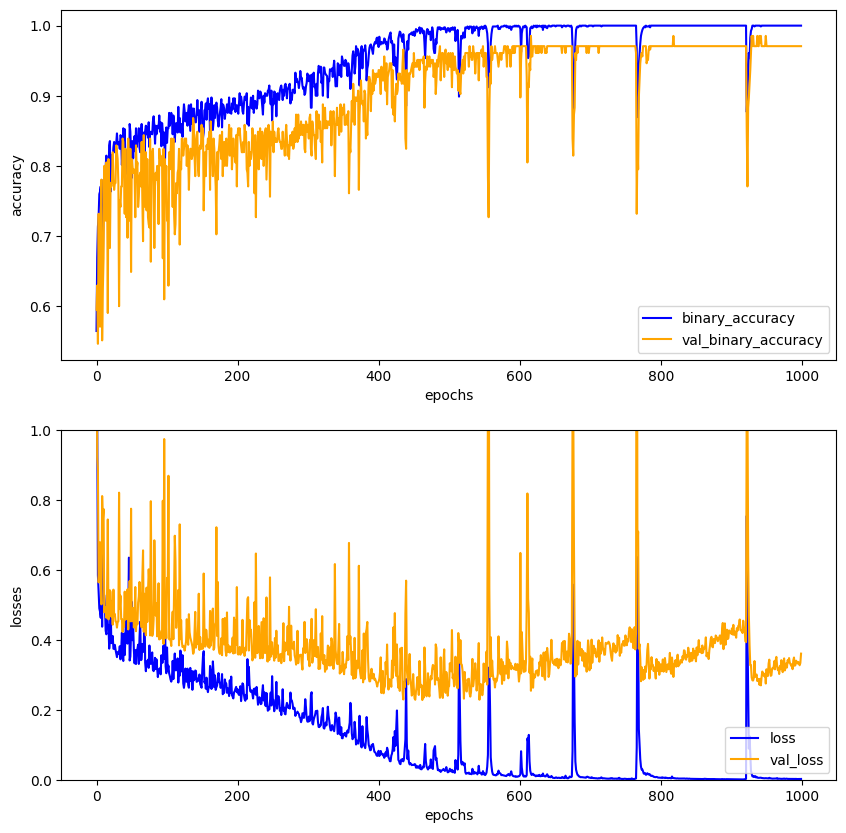

In [73]:
theplot(history)

Metrics


In [74]:
#get predicted
train_predicted=predict(test1, train_data)
test_predicted=predict(test1, test_data)

7/7 [==============================] - 0s 1ms/step


In [75]:
trainmetrics=pd.DataFrame([
    precision_score(train_value,train_predicted),
    recall_score(train_value,train_predicted),
    f1_score(train_value,train_predicted),
    accuracy_score(train_value,train_predicted)])

testmetrics=pd.DataFrame([
    precision_score(test_value,test_predicted),
    recall_score(test_value,test_predicted),
    f1_score(test_value,test_predicted),
    accuracy_score(test_value,test_predicted)])

metrics=pd.concat((trainmetrics, testmetrics), axis=1)
metrics.index=["precision_score", "recall_score", "f1_score", "accuracy_score"]
metrics.columns=["Train", "Test"]
metrics

,Train,Test
precision_score,1.0,1.000000
recall_score,1.0,0.947826
f1_score,1.0,0.973214
accuracy_score,1.0,0.970732


In [65]:
test1.save("Themodel.keras")

## Tuning (Deprcreated)--------------------------------------------------------

### Model and parameter declaration (DNN)

In [13]:
import keras_tuner as kt

In [15]:
#Tuning
def getmodel(hp):
  firsthidden=hp.Int('1st_layer',min_value=4,max_value=32,step=4)
  secondhidden=hp.Int('2nd_layer',min_value=4,max_value=32,step=4)
  
  hp_learning_rate = hp.Choice('learning_rate', values=[ 0.001, 1e-2, 1e-3, 1e-4])
  model = keras.Sequential()
    
  #1st layer
  model.add(keras.layers.Dense(firsthidden, activation='relu', input_dim=X.shape[1]))
  model.add(keras.layers.Dense(secondhidden, activation='relu', input_dim=X.shape[1]))
  
  #output layer
  model.add(keras.layers.Dense(1, activation="sigmoid"))

  #learning rate
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["binary_accuracy"])

  return model

In [16]:
#Running the hyperparamater search with Hyperband methode
currenttime=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

thetuner=kt.Hyperband(getmodel, objective="val_binary_accuracy",                       #Finding the best val_accuracy of the brute!
                      max_epochs=100,
                      factor=2,
                      directory="../logs/",  
                      project_name=currenttime)

Get best model

In [ ]:
#Get the best model and its optimal paramaters
thetuner.search(train_data, train_value, epochs=100, validation_data=(test_data, test_value)) 


best_hps=thetuner.get_best_hyperparameters(num_trials=1)

In [34]:
'''
#Build model with the most optimal hyperparameters and find its optimum epochs
model=thetuner.hypermodel.build(best_hps[0])

process=model.fit(train_data, train_value, epochs=1000, validation_data=(test_data, test_value))

val_binary_accuracy_perepoch = process.history['val_binary_accuracy']
best_epoch = val_binary_accuracy_perepoch.index(max(val_binary_accuracy_perepoch)) + 1
print('Best epoch: %d' % (best_epoch,))
'''

Epoch 1000/1000
26/26 [==============================] - 0s 2ms/step - loss: 0.0114 - binary_accuracy: 1.0000 - val_loss: 0.0095 - val_binary_accuracy: 1.0000


In [25]:
#build model with most optimal hymperparameters and epochs
model=thetuner.hypermodel.build(best_hps[0])

bestmodel=model.fit(train_data, train_value, epochs=1000, validation_data=(test_data, test_value))

Epoch 1/1000
26/26 [==============================] - 1s 12ms/step - loss: 5.0532 - binary_accuracy: 0.4988 - val_loss: 1.1376 - val_binary_accuracy: 0.6000
Epoch 2/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.9985 - binary_accuracy: 0.6463 - val_loss: 0.9164 - val_binary_accuracy: 0.5366
Epoch 3/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.8380 - binary_accuracy: 0.6390 - val_loss: 0.5879 - val_binary_accuracy: 0.6878
Epoch 4/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.5840 - binary_accuracy: 0.7293 - val_loss: 0.7011 - val_binary_accuracy: 0.5707
Epoch 5/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.5180 - binary_accuracy: 0.7366 - val_loss: 0.7205 - val_binary_accuracy: 0.5659
Epoch 6/1000
26/26 [==============================] - 0s 3ms/step - loss: 0.5114 - binary_accuracy: 0.7402 - val_loss: 0.4919 - val_binary_accuracy: 0.8000
Epoch 7/1000
26/26 [==============================] - 0s 3ms/st

Show history of metrics by epoch

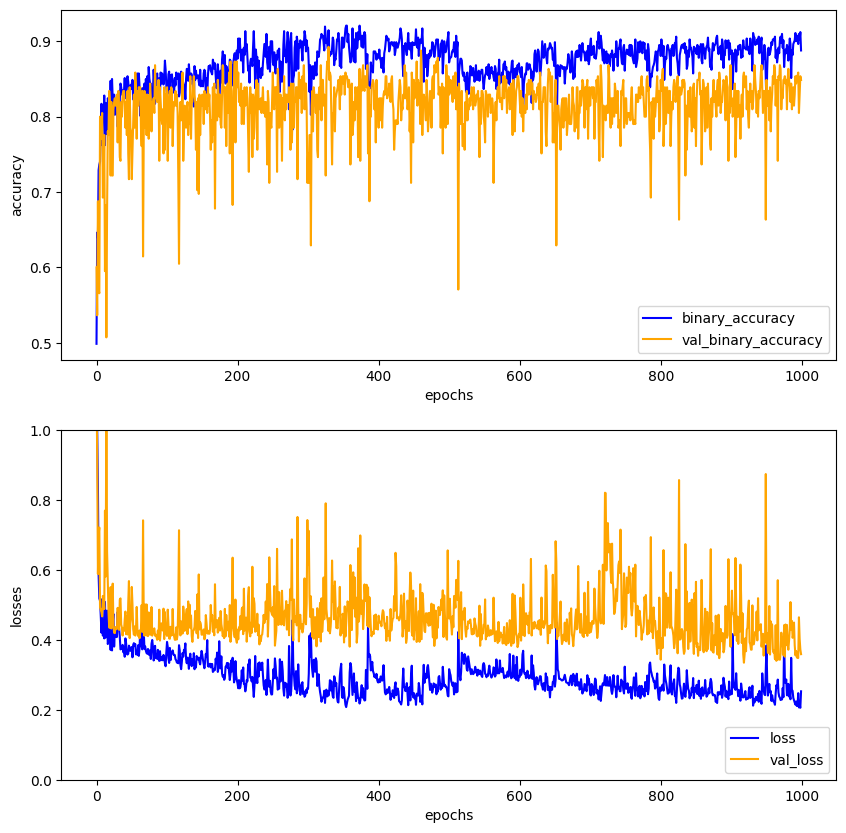

In [26]:
theplot(bestmodel)

### Model and parameter declaration (ANN)

In [27]:
def getmodel(hp):
  model = keras.Sequential()
  
  #1st layer
  hp_units = hp.Int('units', min_value=32, max_value=512, step=32)            #Finding the best layer
  model.add(keras.layers.Dense(hp_units, activation='relu', input_dim=X.shape[1]))
  
  
  #output layer
  model.add(keras.layers.Dense(1, activation="sigmoid"))


  #learning rate
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])  #Finding the best learning rate

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=keras.losses.BinaryCrossentropy(),
                metrics=["binary_accuracy"])

  return model

In [28]:
#Running the hyperparamatere search
currenttime=datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
thetuner=kt.Hyperband(getmodel, objective="val_binary_accuracy",                       #Finding the best val_accuracy of the brute!
                      max_epochs=30,
                      factor=2,
                      directory="../logs/",  
                      project_name=currenttime)

In [29]:
thetuner.search(train_data, train_value, epochs=100, validation_data=(test_data, test_value))               #almost the same as keras.model.sequential.fit


best_hps=thetuner.get_best_hyperparameters(num_trials=1)

Trial 80 Complete [00h 00m 03s]
val_binary_accuracy: 0.6731707453727722

Best val_binary_accuracy So Far: 0.8487805128097534
Total elapsed time: 00h 02m 19s
INFO:tensorflow:Oracle triggered exit


In [30]:
model=thetuner.hypermodel.build(best_hps[0])

process=model.fit(train_data, train_value, epochs=2000, validation_data=(test_data, test_value))

Epoch 1/2000
26/26 [==============================] - 1s 8ms/step - loss: 17.6661 - binary_accuracy: 0.4890 - val_loss: 2.0732 - val_binary_accuracy: 0.5659
Epoch 2/2000
26/26 [==============================] - 0s 2ms/step - loss: 1.1820 - binary_accuracy: 0.6159 - val_loss: 0.7305 - val_binary_accuracy: 0.6927
Epoch 3/2000
26/26 [==============================] - 0s 2ms/step - loss: 0.6057 - binary_accuracy: 0.7341 - val_loss: 0.6062 - val_binary_accuracy: 0.7171
Epoch 4/2000
26/26 [==============================] - 0s 2ms/step - loss: 0.5570 - binary_accuracy: 0.7402 - val_loss: 0.5210 - val_binary_accuracy: 0.7463
Epoch 5/2000
26/26 [==============================] - 0s 2ms/step - loss: 0.5031 - binary_accuracy: 0.7549 - val_loss: 0.4864 - val_binary_accuracy: 0.7659
Epoch 6/2000
26/26 [==============================] - 0s 2ms/step - loss: 0.4273 - binary_accuracy: 0.8000 - val_loss: 0.4667 - val_binary_accuracy: 0.7854
Epoch 7/2000
26/26 [==============================] - 0s 2ms/st

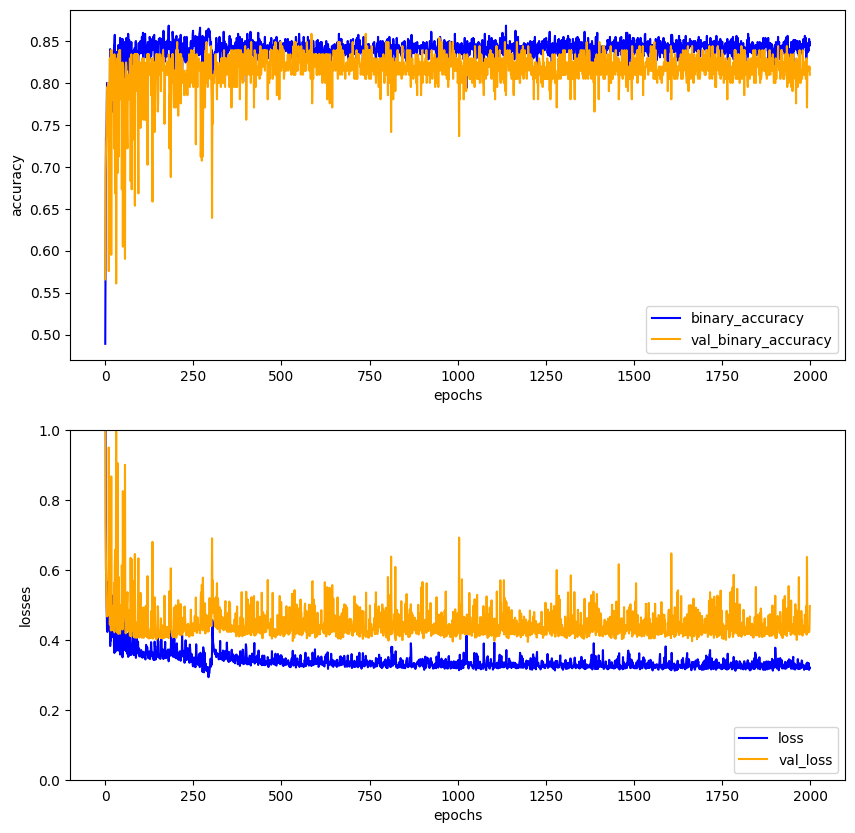

In [31]:
theplot(process)

Metrics

In [ ]:
#get predicted
train_predicted=predict(model, train_data)
test_predicted=predict(model, test_data)

7/7 [==============================] - 0s 2ms/step


In [ ]:
trainmetrics1=pd.DataFrame([
    precision_score(train_value,train_predicted),
    recall_score(train_value,train_predicted),
    f1_score(train_value,train_predicted),
    accuracy_score(train_value,train_predicted)])

testmetrics1=pd.DataFrame([precision_score(test_value,test_predicted),
    recall_score(test_value,test_predicted),
    f1_score(test_value,test_predicted),
    accuracy_score(test_value,test_predicted)])

metrics1=pd.concat((trainmetrics1, testmetrics1), axis=1)
metrics1.index=["precision_score", "recall_score", "f1_score", "accuracy_score"]
metrics1.columns=["Train", "Test"]
metrics1

,Train,Test
precision_score,0.890661,0.873874
recall_score,0.939904,0.881818
f1_score,0.914620,0.877828
accuracy_score,0.910976,0.868293


## Comparison